In [2]:
from sklearn.datasets import fetch_openml
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [3]:
mnist = fetch_openml('mnist_784')

In [4]:
y_df = pd.DataFrame(mnist['target'])
X_df = pd.DataFrame(mnist['data']).astype(float)
data_df = pd.concat([y_df, X_df], axis=1)

In [5]:
data_df.iloc[:,0].value_counts()

class
1    7877
7    7293
3    7141
2    6990
9    6958
0    6903
6    6876
8    6825
4    6824
5    6313
Name: count, dtype: int64

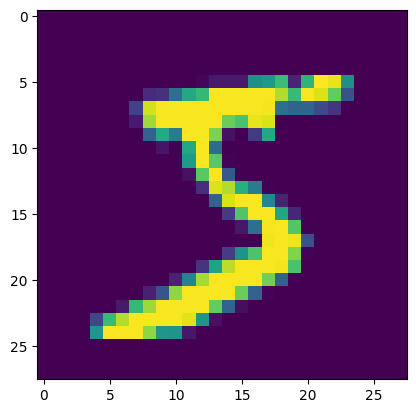

In [6]:
first_image = data_df.iloc[0, 1:].to_numpy(dtype=float)
first_image = first_image.reshape((28, 28))
plt.imshow(first_image)

In [7]:
X = data_df.iloc[:, 1:]
y = data_df.iloc[:, 0]

In [8]:
from sklearn.model_selection import train_test_split
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X, y, test_size=1/7, random_state=42)


In [9]:
train_df = pd.concat([y_train_df, X_train_df], axis=1)
test_df = pd.concat([y_test_df, X_test_df], axis=1)

In [10]:
from skimage.transform import AffineTransform, warp

def shift(X_train_df, y_train_df, vectors):
    # Convert DataFrames to numpy arrays
    X_train_1D = X_train_df.to_numpy()
    X_train_2D = X_train_1D.reshape((len(X_train_1D), 28, 28))
    y_train = y_train_df.to_numpy()
    
    X_shifted = []
    y_shifted = []
    
    for index, img in enumerate(X_train_2D):
        for vector in vectors:
            transform = AffineTransform(translation=vector)
            shifted_img = warp(img, transform, mode='edge', cval=0, preserve_range=True)
            X_shifted.append(shifted_img)
            y_shifted.append(y_train[index])
    
    return np.array(X_shifted), np.array(y_shifted)

In [11]:
X_augmented_2D ,y_augmented = shift(X_train_df, y_train_df, [])

In [12]:
X_augmented_1D = X_augmented_2D.reshape((len(X_augmented_2D),28*28))
X_augmented_1D.shape

(0, 784)

In [13]:
from sklearn.model_selection import KFold
def create_kfolds(X_train_df, y_train_df, X_augmented, y_augmented, cv=3):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    
    train_folds = []
    val_folds = []

    X_augmented_array = X_augmented.to_numpy() if isinstance(X_augmented, pd.DataFrame) else X_augmented
    y_augmented_array = y_augmented.to_numpy() if isinstance(y_augmented, pd.Series) else y_augmented

    if len(X_augmented_array) >= len(X_train_df) * cv:
        X_val = X_train_df.to_numpy()
        y_val = y_train_df.to_numpy()
        print(len(X_train_df))
        for _ in range(cv):
            train_folds.append((X_augmented_array, y_augmented_array))
            val_folds.append((X_val, y_val))
            
    elif len(X_augmented_array) > 0:
        for train_index, val_index in kf.split(X_train_df):
            X_train = X_train_df.iloc[train_index].to_numpy()
            y_train = y_train_df.iloc[train_index].to_numpy()
            
            X_val = X_train_df.iloc[val_index].to_numpy()
            y_val = y_train_df.iloc[val_index].to_numpy()
            
            # Combine original and augmented data
            X_combined_train = np.concatenate((X_train, X_augmented_array))
            y_combined_train = np.concatenate((y_train, y_augmented_array))
            
            train_folds.append((X_combined_train, y_combined_train))
            val_folds.append((X_val, y_val))
    else:
        for train_index, val_index in kf.split(X_train_df):
            X_train = X_train_df.iloc[train_index].to_numpy()
            y_train = y_train_df.iloc[train_index].to_numpy()
            
            X_val = X_train_df.iloc[val_index].to_numpy()
            y_val = y_train_df.iloc[val_index].to_numpy()
            
            train_folds.append((X_train, y_train))
            val_folds.append((X_val, y_val))
            
    return train_folds, val_folds


In [14]:
train_folds, val_folds = create_kfolds(
    X_train_df=X_train_df,
    y_train_df=y_train_df,
    X_augmented=X_augmented_1D,
    y_augmented=y_augmented
    )

9


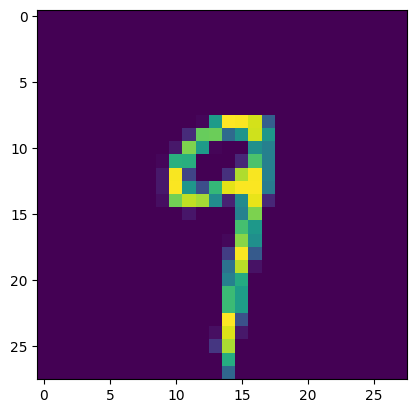

In [15]:
images, labels = train_folds[0]
index = 12423
plt.imshow(images[index].reshape((28,28)))
print(labels[index])

6


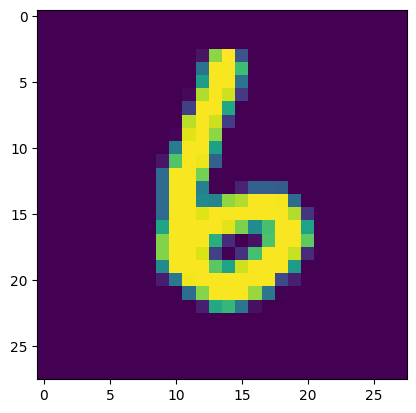

In [16]:
images, labels = val_folds[0]
index = 11234
plt.imshow(images[index].reshape((28,28)))
print(labels[index])

In [17]:
def one_training(sgd_clf, x_train, y_train, x_val, y_val, classes=None):
    if classes is not None:
        sgd_clf.partial_fit(x_train, y_train, classes=classes)
    else:
        sgd_clf.partial_fit(x_train, y_train)
    score = sgd_clf.score(x_val, y_val)
    return score

In [18]:
X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy().astype(int)

In [1]:
import multiprocessing
cores = multiprocessing.cpu_count()/2
cores

12

In [21]:
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

param_grid = {
    'loss': ['hinge', 'log_loss'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'optimal'],
    'max_iter': [1000, 2000],
}
grid_search = GridSearchCV(SGDClassifier(), param_grid, cv=3, n_jobs=cores)
grid_search.fit(X_train,y_train)
print(grid_search.best_params_)

# sgd_clf = SGDClassifier(loss='log_loss')

# pipeline = Pipeline([
#     ('imputer', SimpleImputer(strategy='mean')),
#     ('scaler', StandardScaler()),
# ])

# for fold_index, (X_combined_train, y_combined_train) in enumerate(train_folds):
#     X_val, y_val = val_folds[fold_index]
    
#     X_combined_train_transformed = pipeline.fit_transform(X_combined_train)
    
#     sgd_clf.partial_fit(X_combined_train_transformed, y_combined_train, classes=np.unique(y_combined_train))

#     X_val_transformed = pipeline.transform(X_val)
    
#     score = sgd_clf.score(X_val_transformed, y_val)
    
#     print(f"Fold {fold_index + 1}, Validation Accuracy: {score:f}")

d:\anaconda3\envs\ml_getting_start\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
d:\anaconda3\envs\ml_getting_start\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [ ]:
def predict_digit_recognizer():
    test_df = pd.read_csv('digit-recognizer\\test.csv')
    X_test = pipeline.fit_transform(test_df.to_numpy())
    pred = sgd_clf.predict(X_test)
    predictions_df = pd.DataFrame({
        'ImageId': range(1, len(pred) + 1),
        'Label': pred
    })

    # Save the DataFrame to a CSV file
    predictions_df.to_csv('my_predictions.csv', index=False)